# PokerMate - Stage 2: Object Detection

----


**Problem Statement**
---
Dectect all the card information from a given sample input image which contains more than 1 of the valid playing cards.


**Approach**
----
Transfer Learning using pre-trained model on daily common objects with 24 Billion parameters (YOLO).

**Dataset**
---
Random images of playing cards at different angles sourced from Kaggle under free license.

SOURCE: https://www.kaggle.com/datasets/andy8744/playing-cards-object-detection-dataset/data


----

# 1. Setup

In [ ]:
# connect to GDrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#
# Initialize Basic File paths...
#

import os
root_dir_fp    = "/content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/"
data_fp        = os.path.join(root_dir_fp, "data")
model_fp       = os.path.join(root_dir_fp, "models")
output_fp      = os.path.join(root_dir_fp, "output")

#
# Initialize Configuration File paths...
#
model_save_fp         = model_fp + '/pokermate_stage2_objectDetection.h5'

# 2. Imports

In [ ]:
# Run the following to install required packages
# !pip install pandas numpy tensorflow keras scikit-learn github gitpython pylabel ultralytics

In [ ]:
!pip install ultralytics omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=f66916cc45cbb0cca88d363f35533d82cf260de368e027a7e3a5932af0fe9fed
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [53]:
import os
import sys
import ntpath
import shutil
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import Image as ImageDisplay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
import torch
import cv2
from pathlib import Path
from ultralytics import YOLO

%matplotlib inline

# 3. Dataset

SOURCE: https://www.kaggle.com/datasets/andy8744/playing-cards-object-detection-dataset/data

In [ ]:
## Setting up the dataset

images       = []
annotations  = []
data_yolo    = data_fp + "/stage2_images/"
train_fp     = data_fp + "/stage2_images/train/"
test_fp      = data_fp + "/stage2_images/test/"
val_fp       = data_fp + "/stage2_images/val/"


def setup_dataset_dir(target_fp):
  for file in os.listdir(target_fp):
    file_ext = ntpath.basename(file).rsplit(".", 1)[1].strip().lower()
    if file_ext in ['jpg', 'jpeg', 'png', 'webmp']:
      # image
      images.append(os.path.join(target_fp, file))
    elif file_ext in ['xml', 'exml', 'json']:
      # annotation
      annotations.append(os.path.join(target_fp, file))
    else:
      pass
    # copy images and annotations to a new dir setup
    dest_images_fp = os.path.join(target_fp, "images")
    dest_labels_fp = os.path.join(target_fp, "labels")
    os.mkdir(dest_images_fp)
    os.mkdir(dest_labels_fp)
    for img_fp in images:
      print("moving: {}".format(ntpath.basename(img_fp)))
      shutil.move(img_fp, dest_images_fp)
    for ann_fp in annotations:
      print("moving: {}".format(ntpath.basename(ann_fp)))
      shutil.move(ann_fp, dest_labels_fp)
    return f"Done: {target_fp}!"

def rename_files(images_fp, labels_fp):
  failed = []
  i=0
  for img in tqdm.tqdm(os.listdir(images_fp)):
      file_name = ntpath.basename(img).rsplit(".", 1)[0]
      img_fp = images_fp + img
      label_fp = labels_fp + file_name + ".txt"
      try:
          if Path(img_fp).exists() and Path(label_fp).exists():
              os.rename(img_fp, f"{images_fp}image_{i}.jpg")
              os.rename(label_fp, f"{labels_fp}image_{i}.txt")
          else:
              print("Failed - ", i, img)
              failed.append(img_fp)
      except Exception as e:
          print("ERROR::::", e, i, img)
      i+=1

In [ ]:
# Original dataset had arbitary filenames, cleaned and renamed all the files
# reduced the size of the dataset.
# fp = "./train"
# images_fp = fp + "/images/"
# labels_fp = fp + "/labels/"
# rename_files(images_fp, labels_fp)

# fp = "./val"
# images_fp = fp + "/images/"
# labels_fp = fp + "/labels/"
# rename_files(images_fp, labels_fp)

# fp = "./test"
# images_fp = fp + "/images/"
# labels_fp = fp + "/labels/"
# rename_files(images_fp, labels_fp)


# Convert xml annotations to YOLO txt version (label r, t, l, b coords)
#from pylabel import importer
#dataset = importer.ImportVOC(path=train_fp + "labels/")
#dataset.export.ExportToYoloV5(output_path=train_fp + "labels")
#dataset = importer.ImportVOC(path=test_fp + "labels/")
#dataset.export.ExportToYoloV5(output_path=test_fp + "labels/")

- all sorted!

Directory structure (final):

      - stage2_images
          - train
            - images
                - *.jpg
            - labels
                - *.txt
          - test
            - images
                - *.jpg
            - labels
                - *.txt
          - val
            - images
                - *.jpg
            - labels
                - *.txt
          - pokermate.yaml

Done.

Data is structured and ready for transfer learning.

In [ ]:
## Display

train_data  = data_yolo + "train/labels"
test_data   = data_yolo + "test/labels"
val_data    = data_yolo + "val/labels"

print("::Total Images::\n\n")
print(f"Training Data:\t\t{len(os.listdir(train_data))}")
print(f"Testing Data:\t\t{len(os.listdir(test_data))}")
print(f"Validation Data:\t{len(os.listdir(val_data))}")

::Total Images::


Training Data:		4000
Testing Data:		506
Validation Data:	700


# 4. Visualization

In [ ]:
# Function to convert YOLOv5 format coordinates to OpenCV format
def yolo_to_opencv(box, img_shape):
    x, y, w, h = box
    x_center, y_center = x * img_shape[1], y * img_shape[0]
    box_width, box_height = w * img_shape[1], h * img_shape[0]
    x_min, y_min = int(x_center - box_width / 2), int(y_center - box_height / 2)
    x_max, y_max = int(x_center + box_width / 2), int(y_center + box_height / 2)
    return x_min, y_min, x_max, y_max

def visualize_image(image_fp, label_fp):
  # Path to label and image files
  label_path = label_fp
  img_fp = image_fp

  # Read image
  img_arr = cv2.imread(img_fp)
  img_shape = img_arr.shape[:2]

  # Display the original image
  plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
  plt.title("Original Image")
  plt.axis('off')

  # Read YOLOv5 format label file
  with open(label_path, 'r') as file:
      lines = file.readlines()

  # Iterate through each line in the label file
  for line in lines:
      # Split the line into label, x, y, w, h
      label, x, y, w, h = map(float, line.strip().split())

      # Convert YOLOv5 format to OpenCV format
      x_min, y_min, x_max, y_max = yolo_to_opencv((x, y, w, h), img_shape)

      # Draw bounding box on the image
      color = (0, 255, 0)  # Green color
      thickness = 2
      img_arr = cv2.rectangle(img_arr, (x_min, y_min), (x_max, y_max), color, thickness)

      # Add label text
      label_text = f"{label}"
      font = cv2.FONT_HERSHEY_SIMPLEX
      font_scale = 0.5
      font_thickness = 1
      text_size = cv2.getTextSize(label_text, font, font_scale, font_thickness)[0]
      img_arr = cv2.putText(img_arr, label_text, (x_min, y_min - 5), font, font_scale, color, font_thickness)

  # Display the annotated image
  plt.subplot(1, 2, 2)
  plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
  plt.title("Annotated Image")
  plt.axis('off')

  plt.show()

Lets visualize some raw images, and their corresponding annotations (labels):

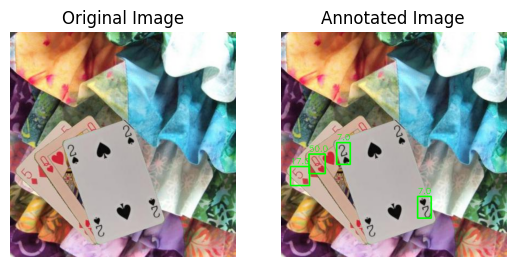

In [ ]:
# sample 1
image_fp   = data_yolo + "/test/images/image_0.jpg"
label_fp   = data_yolo + "/test/labels/image_0.txt"
visualize_image(image_fp, label_fp)

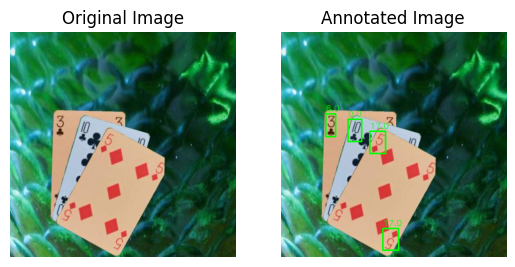

In [ ]:
# sample 2
image_fp   = data_yolo + "/test/images/image_15.jpg"
label_fp   = data_yolo + "/test/labels/image_15.txt"
visualize_image(image_fp, label_fp)

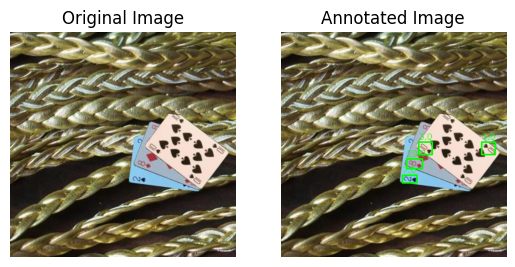

In [ ]:
# sample 3
image_fp   = data_yolo + "/test/images/image_105.jpg"
label_fp   = data_yolo + "/test/labels/image_105.txt"
visualize_image(image_fp, label_fp)

# 5. Transfer Learning using YOLO (Version 8)

Yolo Version 8 is the latest yolo model version.

For this project, we are using `Yolo V8 Nano model` pretrained on COCO data (common objects).

In this version of yolo, we do not need to download the model directory or such, we just need the weights file (.pt).

Yolo version 8 Nano model file is: **yolov8n.pt**

In [ ]:
## LOAD YOLO V8 NANO BASE MODEL

########################################
#
#   BASE MODEL = "yolov8n.pt"
#
########################################


# Base model file path
base_model_fp = model_fp + "/yolov8n.pt"


# Check if model already exists or not...
if Path(base_model_fp).exists():
  print("`Yolo v8 nano` base model Exists. Loading model...")
  base_model = YOLO(base_model_fp)
  print("\n\n*** Model Loaded! **")
else:
  print("Base model couldn't be found! Please download...")

`Yolo v8 nano` base model Exists. Loading model...


*** Model Loaded! **


### 5.1. Direct-shot Prediction (No fine-tuning)

Let's predict without any fine-tuning, or any kind of training. Just load the model, and predict on the fly using the common base model on raw images.

In [ ]:
# Let's predic
def predict(model, image_fp):

  # Model Inference
  results = model(image_fp)

  # Display
  for r in results:
    #print(r.boxes)
    if len(r.boxes.cls):
      label = int(r.boxes.cls[0])
      print(model.names.get(label))
      im_array = r.plot()  # plot a BGR numpy array of predictions
      im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
      im.show()
      plt.imshow(im)
    else:
      print("\n\nFailed to detect this image.")


WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/test/images/image_501.jpg: 640x480 1 spoon, 1 dining table, 1 book, 63.4ms
Speed: 7.0ms preprocess, 63.4ms inference, 1977.4ms postprocess per image at shape (1, 3, 640, 480)
spoon


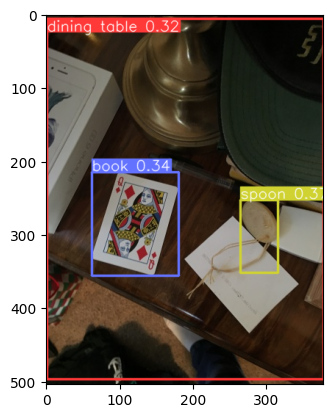

In [ ]:
# direct-shot prediction - try #1

predict(base_model, image_fp = data_fp + "/stage2_images/test/images/image_501.jpg")


image 1/1 /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/test/images/image_502.jpg: 640x480 3 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)
person


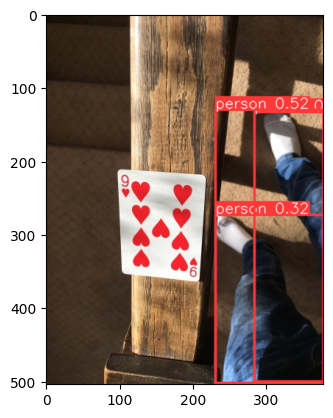

In [ ]:
# direct-shot prediction - try #2

predict(base_model, image_fp = data_fp + "/stage2_images/test/images/image_502.jpg")


image 1/1 /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/test/images/image_504.jpg: 640x480 1 book, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
book


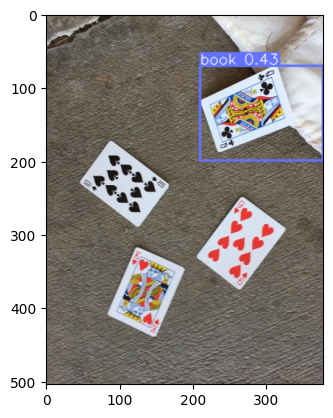

In [ ]:
# direct-shot prediction - try #3

predict(base_model, image_fp = data_fp + "/stage2_images/test/images/image_504.jpg")

- As expected, the model fails terribly.

- As evident, the base model is not trained to detect playing cards, and since the images have a lot of clutter, it's mis-classifying images into other common objects, like books etc. Since it has not been trained or tuned on playing cards, it fails to recognize or detect them miserably!

- Next is fine-tuning to transfer learn it to recognize playing cards.

- Fine-tuning on custom data

---

# 6. Fine-tuning

In [ ]:
## Fine-tune the Yolo Base Nano Model on our dataset - Playing Cards!


# Load the base model which shall be fine-tuned...
model = YOLO(base_model_fp)
print(f"\n\nBase model loaded:\n{base_model_fp}\n\n\n")

# Training model
print("\n\n<<<<<<<< FINE TUNING... >>>>>>>>>>>>\n\n")
results = model.train(data    = data_fp + "/stage2_images/pokermate.yaml",
                      imgsz   = 416,
                      epochs  = 100,
                      batch   = 250,
                      name    = output_fp + "/pokermate_stage2_yolo8_best.pt")

# Save the model
model.export()



Base model loaded:
/content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/models/yolov8n.pt





<<<<<<<< FINE TUNING... >>>>>>>>>>>>


Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/models/yolov8n.pt, data=/content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/pokermate.yaml, epochs=10, patience=50, batch=250, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=pokermate_stage2_yolo8_best.pt, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, determin

100%|██████████| 755k/755k [00:00<00:00, 93.1MB/s]

Overriding model.yaml nc=80 with nc=52

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 225 layers, 3020988 parameters, 3020972 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/output/pokermate_stage2_yolo8_best.pt', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 329MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/val/labels.cache... 700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 700/700 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/output/pokermate_stage2_yolo8_best.pt/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000179, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001953125), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/output/pokermate_stage2_yolo8_best.pt
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_

       1/10      14.1G      2.178      5.964      1.392        936        416: 100%|██████████| 16/16 [01:30<00:00,  5.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [05:13<00:00, 156.65s/it]

                   all        700       2633          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      14.1G      1.506      5.538      1.046        940        416: 100%|██████████| 16/16 [00:46<00:00,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all        700       2633          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      14.1G      1.164      4.986     0.8906        923        416: 100%|██████████| 16/16 [00:52<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.87s/it]

                   all        700       2633    0.00354     0.0419    0.00244    0.00174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      14.1G      1.067      4.494     0.8565        928        416: 100%|██████████| 16/16 [00:45<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]


                   all        700       2633     0.0137      0.416     0.0118    0.00909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      14.1G      1.006      4.169     0.8444        924        416: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.27s/it]


                   all        700       2633     0.0124      0.529     0.0145     0.0117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      14.1G     0.9459      3.907     0.8411        930        416: 100%|██████████| 16/16 [00:46<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.68s/it]


                   all        700       2633     0.0139      0.569     0.0204     0.0166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      14.1G     0.8983      3.708     0.8352        942        416: 100%|██████████| 16/16 [00:44<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.66s/it]


                   all        700       2633     0.0143      0.767     0.0304     0.0249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      14.1G     0.8723       3.52     0.8332        942        416: 100%|██████████| 16/16 [00:45<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.68s/it]


                   all        700       2633     0.0174      0.776     0.0388     0.0322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      14.1G     0.8471      3.371     0.8307        916        416: 100%|██████████| 16/16 [00:45<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.43s/it]


                   all        700       2633     0.0166      0.906     0.0479     0.0396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      14.1G     0.8334      3.279     0.8312        938        416: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.30s/it]


                   all        700       2633      0.207     0.0749     0.0584     0.0484

10 epochs completed in 0.267 hours.
Optimizer stripped from /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/output/pokermate_stage2_yolo8_best.pt/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/output/pokermate_stage2_yolo8_best.pt/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/output/pokermate_stage2_yolo8_best.pt/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3015788 parameters, 0 gradien

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.86s/it]


                   all        700       2633      0.207     0.0745     0.0585     0.0485
                   10C        700         49          1          0     0.0482     0.0407
                   10D        700         40          0          0     0.0555     0.0441
                   10H        700         56      0.143     0.0179     0.0262     0.0197
                   10S        700         30     0.0531     0.0333     0.0959     0.0697
                    2C        700         56     0.0704      0.107     0.0597     0.0513
                    2D        700         44     0.0181     0.0455      0.036     0.0308
                    2H        700         48     0.0511     0.0417     0.0409     0.0354
                    2S        700         57          1          0     0.0476     0.0382
                    3C        700         69      0.107      0.304      0.123      0.105
                    3D        700         43     0.0523      0.163     0.0467     0.0391
                    3

'/content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/output/pokermate_stage2_yolo8_best.pt/weights/best.torchscript'

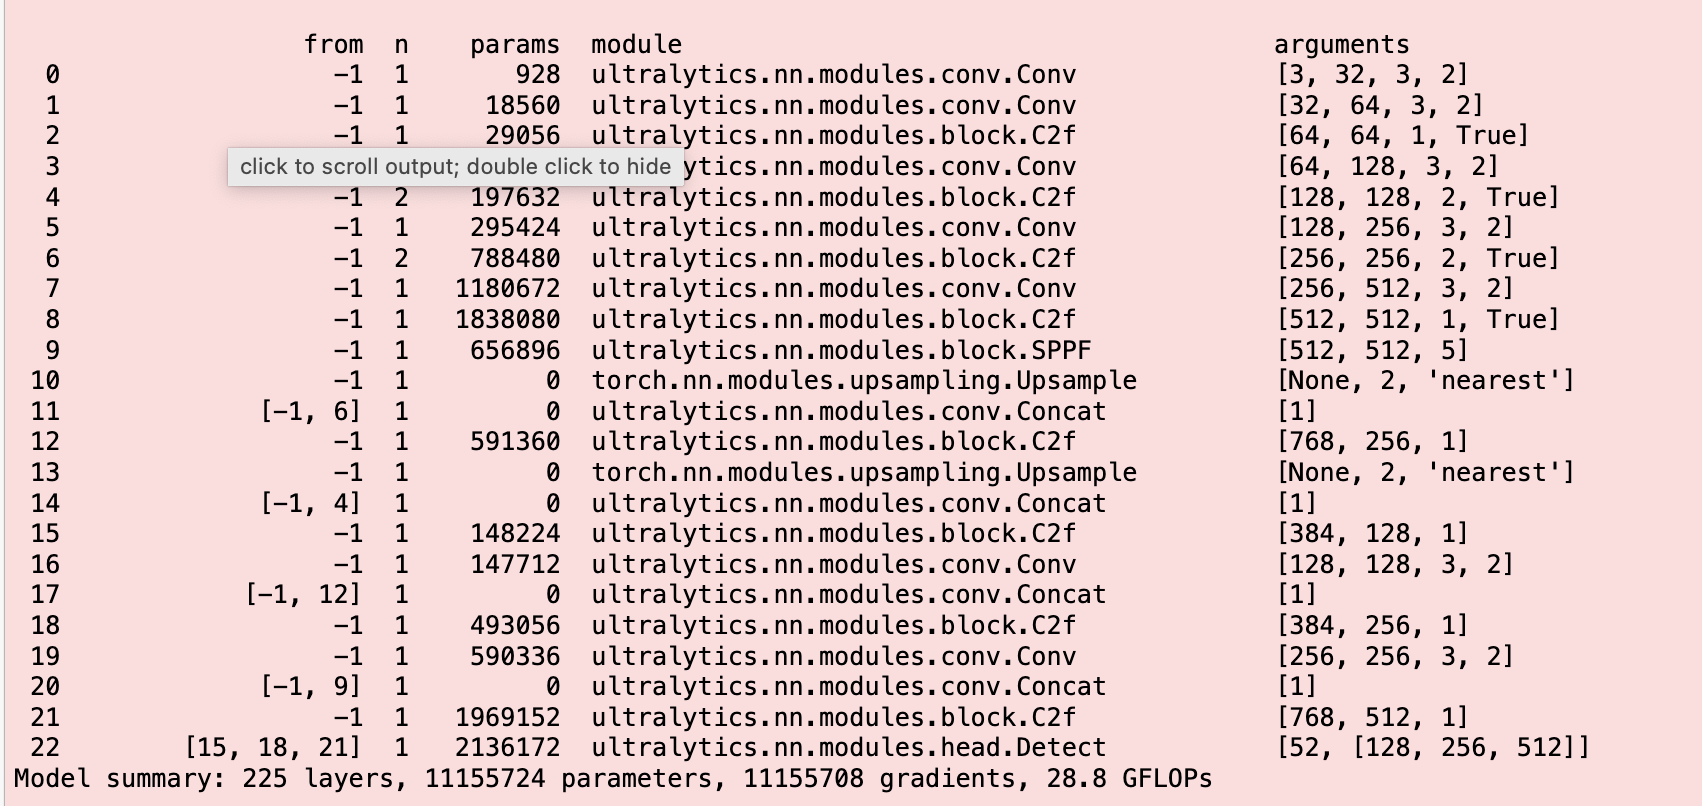

In [54]:
## Final model training on 250 epochs...


ImageDisplay(filename=output_fp + '/final_model_1.png', width=800)

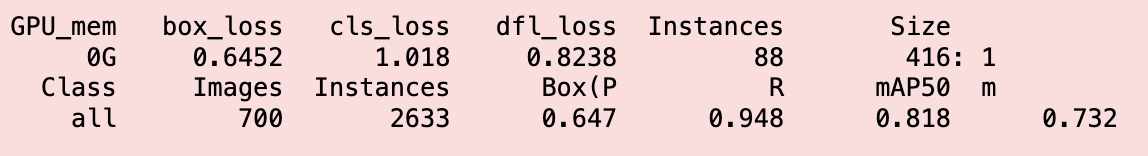

In [55]:
ImageDisplay(filename=output_fp + '/final_model_2.png', width=800)

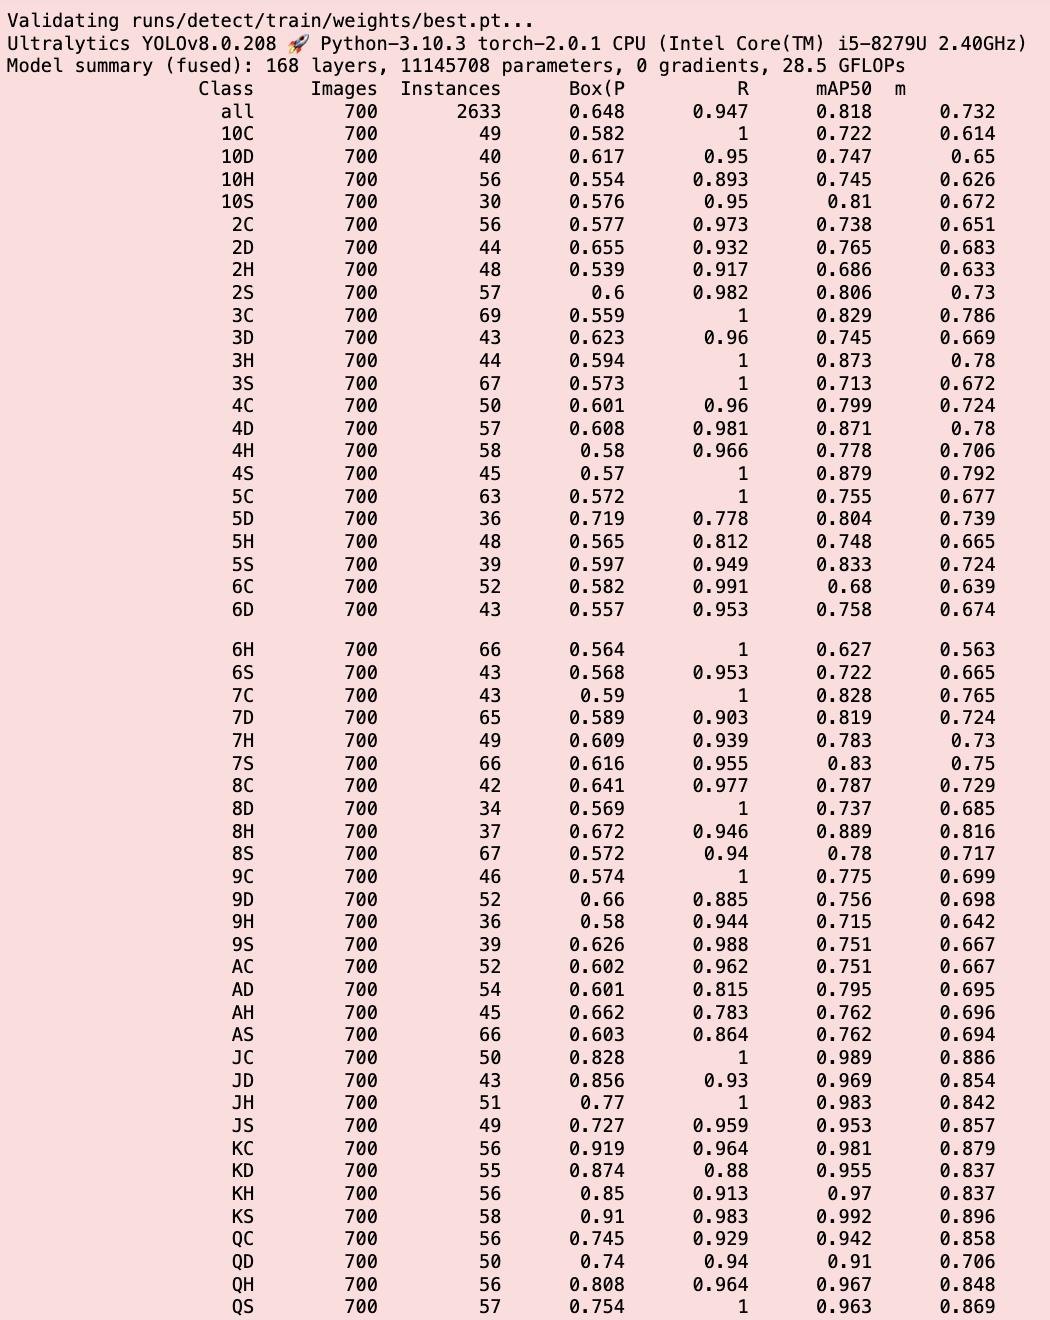

In [56]:
ImageDisplay(filename=output_fp + '/final_model_3.png', width=800)

- Takes about 11 hrs to complete.
- Dry Run for 10 epochs is shown above.
- Final model file saved: "pokermate_stage2_yolo8.pt

**Model training configuration params:**

- task: Whether we want to detect, segment, or classify on the dataset of our choice.
- mode: Mode can either be train, val, or predict. As we are running training, it should be train.
- model: The model that we want to use. Here, we use the YOLOv8 Nano model pretrained on the COCO dataset, i.e. 'yolov8n.pt'

- imgsz: The image size. The default resolution is 640.

- data: Path to the dataset YAML file located in dataset folder.

- epochs: Number of epochs we want to train for.

- batch: The batch size for data loader. You may increase or decrease it according to your GPU memory availability.

- name: Name of the results directory for runs/detect.



In [57]:
## Now the model has been fine-tuned!!!

src  = """/content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/output/pokermate_stage2_yolo8.pt/weights/best.pt"""
dest = model_fp + "/pokermate_stage2_yolo8.pt"

# shutil.copy(src, dest)

## check model
if Path(model_fp + "/pokermate_stage2_yolo8.pt").exists():
  print("Fine-tuned model found!")

Fine-tuned model found!


# 7. Model Prediction

In [58]:
## Let's use the fine-tuned model now!!


# Loading fine-tuned model for cards:
model = YOLO(model_fp + '/pokermate_stage2_yolo8.pt')
print("\n\n** Fine-tuned model loaded! **\n\n")



** Fine-tuned model loaded! **




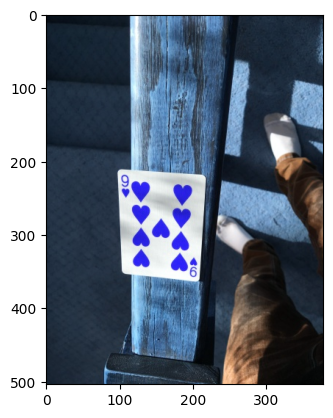

In [59]:
## original image

img_fp  = data_fp + "/stage2_images/test/images/image_502.jpg"
img_arr = cv2.imread(img_fp)
plt.imshow(img_arr)


image 1/1 /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/test/images/image_502.jpg: 416x320 2 9Hs, 12.9ms
Speed: 1.5ms preprocess, 12.9ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 320)


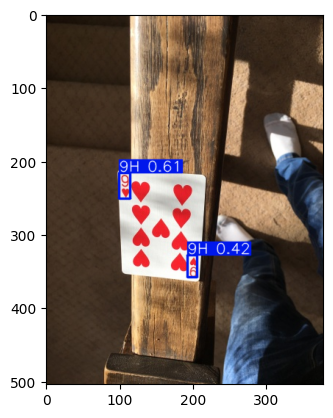

In [60]:
## inferenced image

# prediction
results = model(img_fp)

# View results
for r in results:
    #print(r.boxes)
    label = int(r.boxes.cls[0])
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()
    plt.imshow(im)
    im.save(output_fp + '/results.jpg')


image 1/1 /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/test/images/image_503.jpg: 416x320 2 10Ss, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 320)


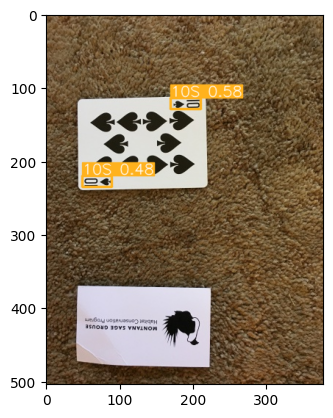

In [61]:
## another!

img_fp  = data_fp + "/stage2_images/test/images/image_503.jpg"
# prediction
results = model(img_fp)
# View results
for r in results:
    #print(r.boxes)
    label = int(r.boxes.cls[0])
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()
    plt.imshow(im)
    im.save(output_fp + '/results.jpg')

image_83.jpg

image 1/1 /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/test/images/image_83.jpg: 416x416 4 2Hs, 1 4H, 1 7S, 15.7ms
Speed: 1.1ms preprocess, 15.7ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)
image_340.jpg

image 1/1 /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/test/images/image_340.jpg: 416x416 4 2Ds, 3 5Ss, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)
image_111.jpg

image 1/1 /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/data/stage2_images/test/images/image_111.jpg: 416x416 1 3H, 4 3Ss, 1 9H, 15.4ms
Speed: 1.0ms pr

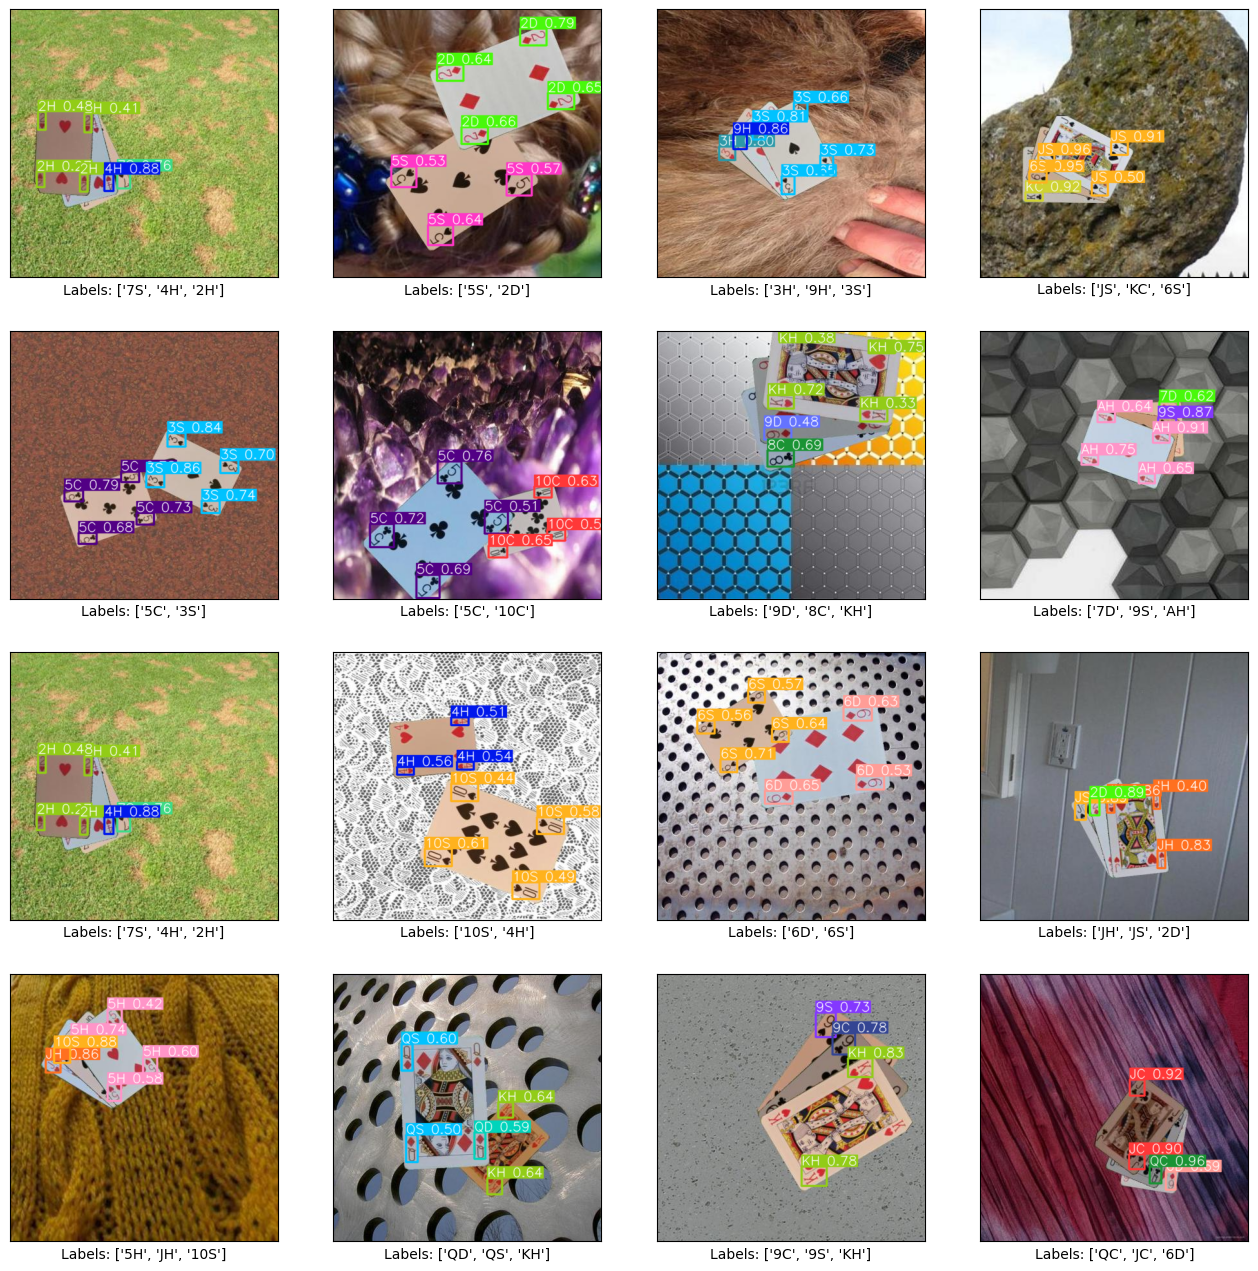

In [62]:
# Lets visualize some predictions...

test_data_fp = data_fp + "/stage2_images/test/images/"
testing_data = os.listdir(test_data_fp)

plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # pick a random image
    index = np.random.randint(0, len(testing_data))
    img_name = testing_data[index]
    print(img_name)
    img_fp = test_data_fp + img_name
    #plt.imshow(img_fp)

    # inference
    results = model(img_fp)

    # View results
    for r in results:
        #print(r.boxes)
        try:
          # GPU VERSION
          labels = set(np.array(r.boxes.cls).astype(int))
        except Exception as e:
          # CPU VERSION
          labels = set(np.array(r.boxes.cls.cpu()).astype(int))
        class_labels = [model.names.get(x) for x in labels]
        im_array = r.plot()
        im = Image.fromarray(im_array[..., ::-1])
        im.show()
        plt.imshow(im)
        plt.xlabel(f"Labels: {class_labels}")

plt.show()

In [64]:
# final model architecture:

model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   

Model has been fine-tuned and works well enough.

X - X

----
----